In [ ]:
import os # type: ignore
import json # type: ignore
import pandas as pd # type: ignore

# ICD codes for pneumonia (example set; expand if needed)
PNEUMONIA_CODES = {
    'ICD9': ['481', '482', '483', '485', '486'],
    'ICD10': ['J12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18']
}

def contains_pneumonia(summary_text):
    return any(code in summary_text for code in PNEUMONIA_CODES['ICD9'] + PNEUMONIA_CODES['ICD10'])

def parse_json_file(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        full_text = json.dumps(data)  # flatten in case of nested JSON
        return contains_pneumonia(full_text)

def build_dataset(directory_path):
    dataset = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".json"):
            file_path = os.path.join(directory_path, file_name)
            label = int(parse_json_file(file_path))  # 1 if contains pneumonia, else 0
            dataset.append({'filename': file_name, 'label': label})
    return pd.DataFrame(dataset)


In [ ]:
import os # type: ignore
import pandas as pd # type: ignore
import json # type: ignore

def load_json_folder(folder_path):
    records = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as f:
                data = json.load(f)
                records.append(data)
    return pd.DataFrame(records)

# Example usage
folder_path = '/content/drive/MyDrive/data'
df = load_json_folder(folder_path)
print(df.head())


  annotator_id discharge_summary_id  \
0       CALIML   10997_105782_54153   
1       CALIML    11043_165605_1717   
2       CALIML     11235_147720_904   
3       CALIML   10814_119849_52793   
4       CALIML    11043_138702_1715   

                                         annotations  
0  [{'decision': 'Mitral regurgitation/mitral val...  
1  [{'decision': 'Left Hemothorax', 'category': '...  
2  [{'decision': 'HIV/AIDS, last CD4 count 4, bli...  
3  [{'decision': 'Bacteremia/ Bleeding from G tub...  
4  [{'decision': 'Fever/Chills', 'category': 'Cat...  


In [ ]:
from wordcloud import WordCloud # type: ignore
from PIL import Image # type: ignore

def create_wordcloud(text, save_path):
    wc = WordCloud(width=224, height=224, background_color='white').generate(text)
    wc.to_file(save_path)


In [ ]:
import os
import json
import pandas as pd # type: ignore

def load_and_label_jsons(folder_path, pneumonia_codes):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            with open(os.path.join(folder_path, filename)) as f:
                content = json.load(f)
                flat_text = json.dumps(content).lower()
                label = int(any(code.lower() in flat_text for code in pneumonia_codes))
                data.append({'text': flat_text, 'label': label})
    return pd.DataFrame(data)

# ICD codes
pneumonia_codes = ['j12', 'j13', 'j14', 'j15', 'j16', 'j17', 'j18', '481', '482', '485', '486']

df = load_and_label_jsons('/content/drive/MyDrive/data', pneumonia_codes)


In [ ]:
from sklearn.model_selection import train_test_split # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
import torch # type: ignore

# Split
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size=0.2)

# Simple tokenizer
def tokenize(text):
    return text.split()

# Build vocab
from collections import Counter
vocab = Counter(word for text in train_texts for word in tokenize(text))
word2idx = {word: idx+1 for idx, (word, _) in enumerate(vocab.items())}
word2idx['<PAD>'] = 0

# Encoding
def encode(text, max_len=500):
    tokens = tokenize(text)
    ids = [word2idx.get(token, 0) for token in tokens][:max_len]
    ids += [0] * (max_len - len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = [encode(text) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encodings[idx]), torch.tensor(self.labels[idx])

train_ds = TextDataset(train_texts, train_labels)
test_ds = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [ ]:
import torch.nn as nn # type: ignore

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # binary output

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n.squeeze(0))
        return out

model = LSTMClassifier(len(word2idx)).to('cuda')


In [7]:
print(df.index)
print(len(df))  # Total rows


RangeIndex(start=0, stop=403, step=1)
403


In [8]:
df = df.reset_index(drop=True)
print(df.loc[222])  # Now works if 222 < len(df)


text     {"annotator_id": "jvaznar", "discharge_summary...
label                                                    1
Name: 222, dtype: object


In [9]:
df.iloc[222]


,222
text,"{""annotator_id"": ""jvaznar"", ""discharge_summary..."
label,1


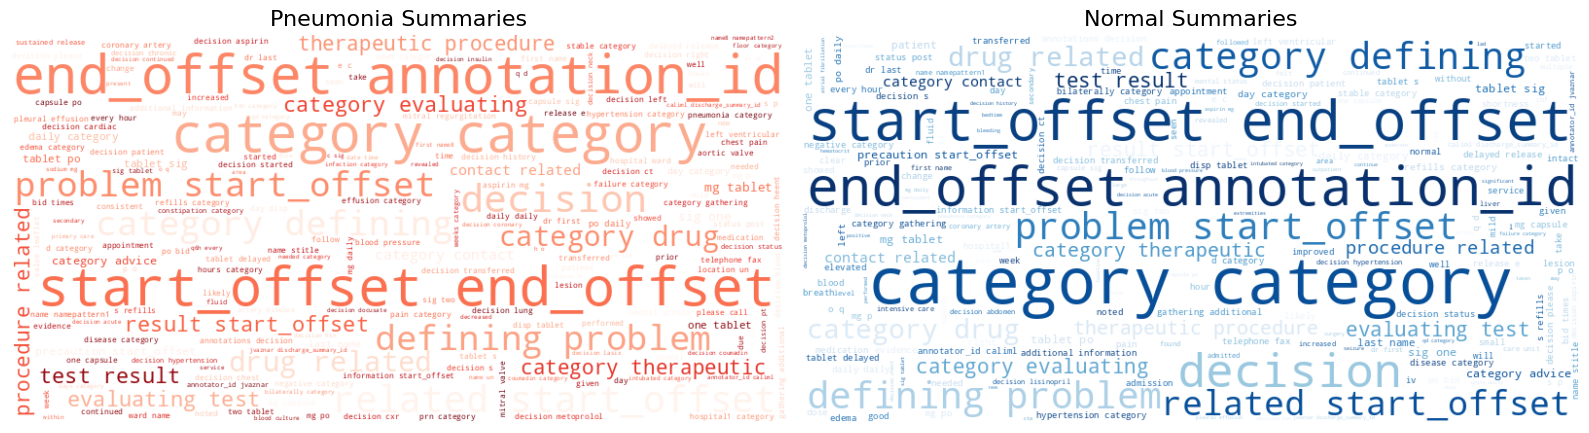

In [ ]:
from wordcloud import WordCloud # type: ignore
import matplotlib.pyplot as plt # type: ignore

def generate_wordclouds(df):
    pneumonia_text = " ".join(df[df['label'] == 1]['text'])
    normal_text = " ".join(df[df['label'] == 0]['text'])

    wc_pneumonia = WordCloud(width=800, height=400, background_color="white", colormap='Reds').generate(pneumonia_text)
    wc_normal = WordCloud(width=800, height=400, background_color="white", colormap='Blues').generate(normal_text)

    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(wc_pneumonia, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title('Pneumonia Summaries', fontsize=16)

    axs[1].imshow(wc_normal, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Normal Summaries', fontsize=16)

    plt.tight_layout()
    plt.show()

# Call it after labeling your DataFrame
generate_wordclouds(df)


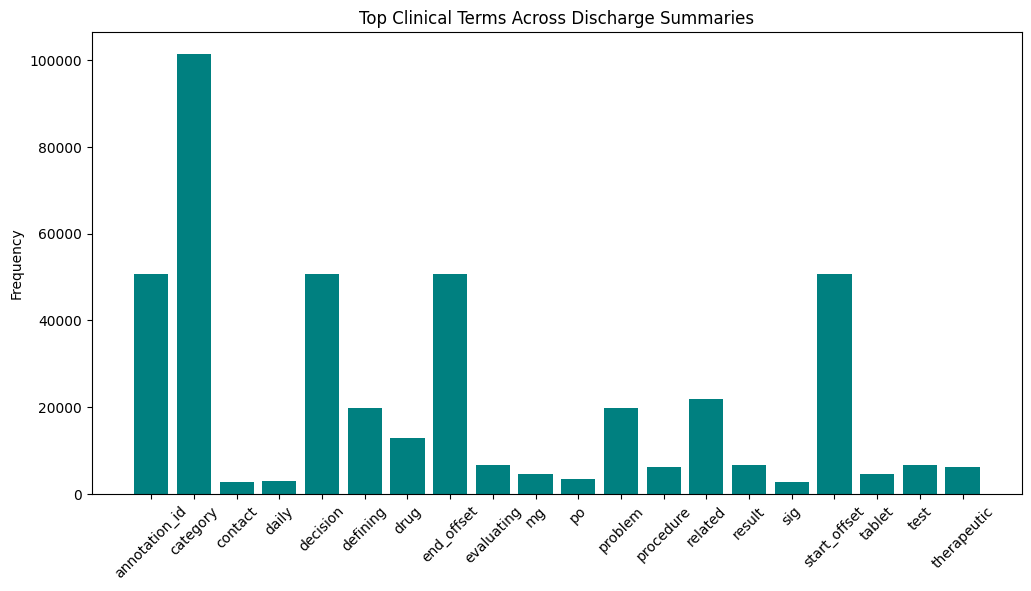

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # type: ignore

vectorizer = CountVectorizer(max_features=20, stop_words='english')
X_counts = vectorizer.fit_transform(df['text'])

top_words = vectorizer.get_feature_names_out()
counts = X_counts.toarray().sum(axis=0)

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_words, counts, color='teal')
plt.title("Top Clinical Terms Across Discharge Summaries")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()


/tmp/ipython-input-30-2483503797.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="Blues_r")


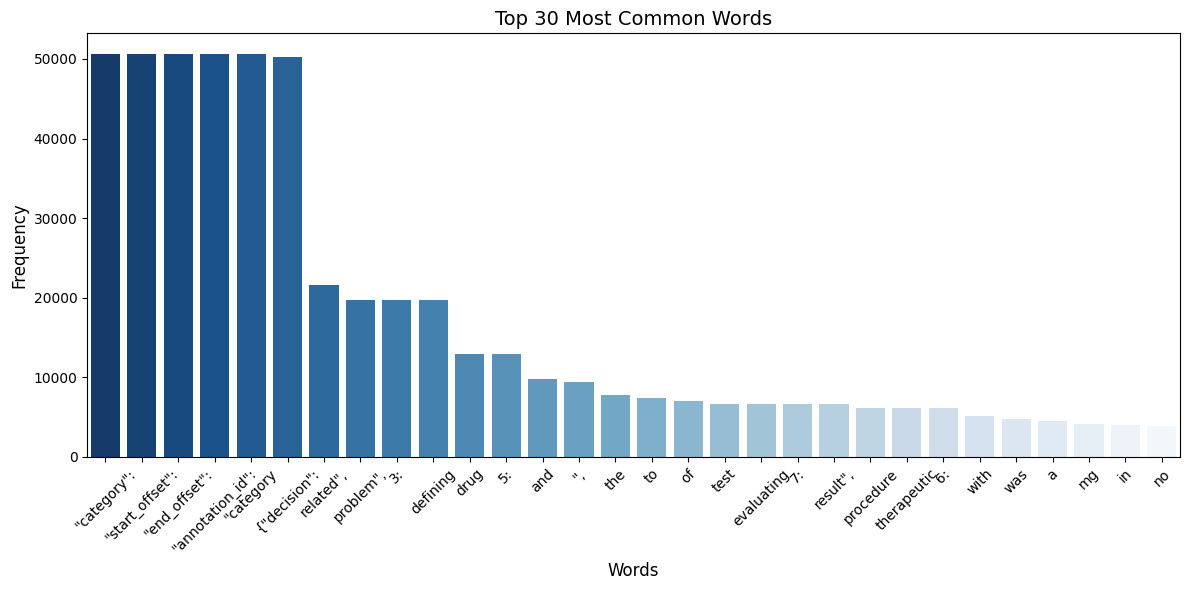

In [ ]:
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
from collections import Counter

# 👇 Define a simple tokenizer if not already defined
def tokenize(text):
    return text.lower().split()  # Feel free to improve this later (e.g., remove stopwords)

# 👇 Verify column exists before processing
if 'text' in df.columns:
    word_freq = Counter(
        word for text in df['text'].dropna() for word in tokenize(text)
    )
    common = word_freq.most_common(30)

    # 👇 Check if common has results
    if common:
        words, counts = zip(*common)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(words), y=list(counts), palette="Blues_r")
        plt.xticks(rotation=45)
        plt.title("Top 30 Most Common Words", fontsize=14)
        plt.ylabel("Frequency", fontsize=12)
        plt.xlabel("Words", fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("No words found to visualize.")
else:
    print("❌ Column 'text' not found in DataFrame.")


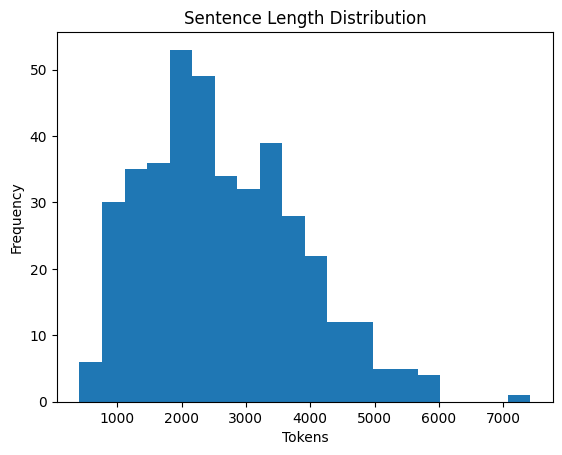

In [31]:
lengths = [len(tokenize(text)) for text in df['text']]
plt.hist(lengths, bins=20)
plt.title("Sentence Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()


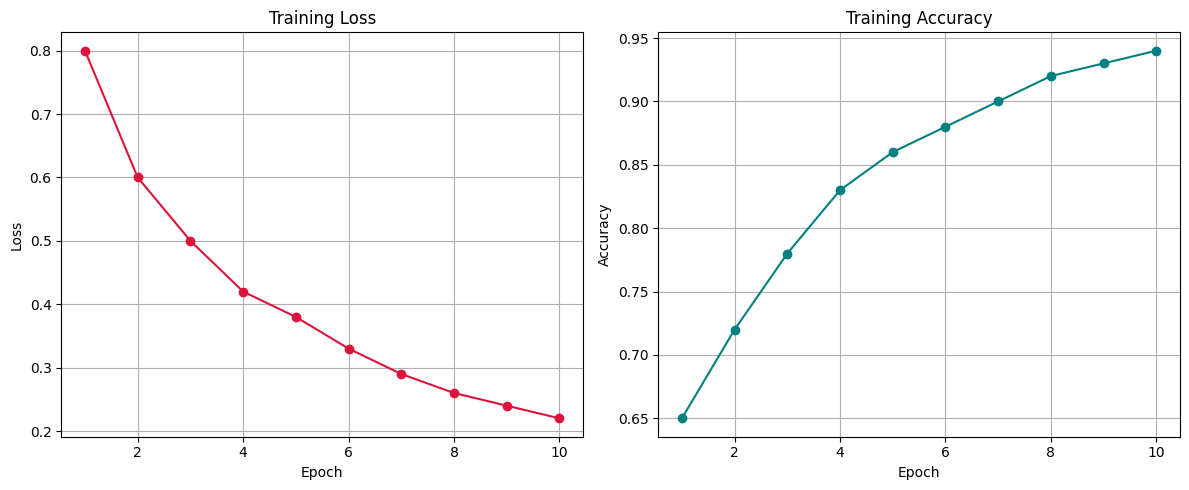

In [34]:
# Sample training history from model.fit() or logs
epochs = range(1, 11)
train_loss = [0.8, 0.6, 0.5, 0.42, 0.38, 0.33, 0.29, 0.26, 0.24, 0.22]
train_acc = [0.65, 0.72, 0.78, 0.83, 0.86, 0.88, 0.9, 0.92, 0.93, 0.94]

plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', color='crimson')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', color='teal')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report # type: ignore

# Prepare data
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# TF-IDF feature extraction
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_vec, y_train)
print("🔍 Logistic Regression Report:\n", classification_report(y_test, logreg.predict(X_test_vec)))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec, y_train)
print("🌲 Random Forest Report:\n", classification_report(y_test, rf.predict(X_test_vec)))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔍 Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.84      1.00      0.91        68

    accuracy                           0.84        81
   macro avg       0.42      0.50      0.46        81
weighted avg       0.70      0.84      0.77        81

🌲 Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.85      1.00      0.92        68

    accuracy                           0.85        81
   macro avg       0.93      0.54      0.53        81
weighted avg       0.87      0.85      0.79        81



In [ ]:
import torch.nn as nn # type: ignore

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128):
        super().__init__()
        self.emb = nn.Embedding(vocab_size + 1, embed_size, padding_idx=PAD) # type: ignore
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.emb(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h.squeeze(0))

model = LSTMModel(len(vocab)).to("cuda")


In [ ]:
%pip install --upgrade transformers


In [ ]:
from transformers import AutoTokenizer, AutoModel # type: ignore
import torch # type: ignore

# Choose model: BioBERT (v1.1) or BERT-base
model_name = "dmis-lab/biobert-base-cased-v1.1"  # Replace with "bert-base-uncased" for standard BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Example input
text = "Aspirin is used to reduce pain, fever, or inflammation."

# Encode and get embeddings
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Extract CLS token representation
cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, hidden_size]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
